In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tensorflow_io as tfio
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import noisereduce as nr
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
import re


In [ ]:
# Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
def load_wav_16k_mono(filename, lowcut=300, highcut=3400, fs=16000):
    # Load the file
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)

    # Cast sample rate to int64
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    # Resample to 16000 Hz
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=fs)

    # Convert to numpy for further processing
    wav_np = wav.numpy()

    # Bandpass filter
    wav_np = butter_bandpass_filter(wav_np, lowcut, highcut, fs)

    # Noise reduction using spectral gating (you can adjust parameters as needed)
    wav_np = nr.reduce_noise(y=wav_np, sr=fs)

    # Normalize the audio signal
    wav_np = wav_np / np.max(np.abs(wav_np))

    # Convert back to tensor
    wav = tf.convert_to_tensor(wav_np, dtype=tf.float32)

    return wav

In [ ]:
# 2. Plotting the wav file
file_name_1="Audio_Work/birth_inference_hours_wav/output_2023-10-09_06-33-01/output_2023-10-09_06-31-35.wav" # birth call instance 1
file_name_3="Audio_Work/birth_inference_hours_wav/output_2023-11-04_06-31-01/output_2023-11-04_06-31-38.wav" # birth call instance 3


birth_wave_1 = load_wav_16k_mono(file_name_1)
birth_wave_3=load_wav_16k_mono(file_name_3)
plt.plot(birth_wave_1)
plt.plot(birth_wave_3)

plt.show()

In [ ]:
def plot_waveforms_from_directories_in_batches(*directories, batch_size=8):
    for directory in directories:
        if os.path.exists(directory) and os.path.isdir(directory):
            wav_files = [f for f in os.listdir(directory) if f.endswith('.wav')]
            for i in range(0, len(wav_files), batch_size):
                batch_files = wav_files[i:i+batch_size]
                plt.figure(figsize=(10, 6))  # Need to work on this
                for filename in batch_files:
                    filepath = os.path.join(directory, filename)
                    waveform = load_wav_16k_mono(filepath)
                    plt.plot(waveform, label=f"{filename}")
                date_label_match = re.search(r'\d{4}-\d{2}-\d{2}', str(directories)).group(0)
                plt.xlabel("Time")
                plt.ylabel("Amplitude")
                plt.title(f"Waveforms of {date_label_match} (Batch {i // batch_size + 1})")
                plt.legend()
                plt.show()
        else:
            print(f"Directory {directory} does not exist or is not a directory.")

In [ ]:
audio_directory="Audio_Work/birth_inference_minutes_wav/output_2023-10-09_06-33-01"
plot_waveforms_from_directories_in_batches(audio_directory)


In [ ]:
audio_directory="Audio_Work/birth_inference_minutes_wav/output_2023-11-04_06-31-01"
plot_waveforms_from_directories_in_batches(audio_directory)


In [ ]:
# Function to extract MFCC features from a WAV file
def extract_mfcc_features(filename, n_mfcc=13):
    audio, sample_rate = librosa.load(filename, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
    return mfccs

# Function to find similarities and plot waveforms
def plot_waveforms_based_on_similarity(directory, similarity_threshold=0.8):
    if not os.path.isdir(directory):
        print(f"Directory {directory} does not exist.")
        return

    wav_files = [f for f in os.listdir(directory) if f.endswith('.wav')]
    mfcc_features = [extract_mfcc_features(os.path.join(directory, f)) for f in wav_files]

    # Initialize similarity matrix
    similarity_matrix = np.zeros((len(wav_files), len(wav_files)))

    # Compute similarities
    for i in range(len(wav_files)):
        for j in range(len(wav_files)):
            if i != j:
                similarity = cosine_similarity(mfcc_features[i].T, mfcc_features[j].T).mean()
                similarity_matrix[i, j] = similarity

    # Identify similar and distinct files
    similar_files = set()
    distinct_files = set(wav_files)

    for i in range(len(wav_files)):
        for j in range(len(wav_files)):
            if similarity_matrix[i, j] >= similarity_threshold:
                similar_files.add(wav_files[i])
                similar_files.add(wav_files[j])
                if wav_files[i] in distinct_files:
                    distinct_files.remove(wav_files[i])
                if wav_files[j] in distinct_files:
                    distinct_files.remove(wav_files[j])

    # Plot waveforms of similar files
    if similar_files:
        plt.figure(figsize=(10, 6))
        for filename in similar_files:
            filepath = os.path.join(directory, filename)
            waveform = load_wav_16k_mono(filepath)
            plt.plot(waveform, label=filename)
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.title(f"Similar Waveforms (Threshold: {similarity_threshold})")
        plt.legend()
        plt.show()

    # Plot waveforms of distinct files
    for filename in distinct_files:
        plt.figure(figsize=(10, 6))
        filepath = os.path.join(directory, filename)
        waveform = load_wav_16k_mono(filepath)
        plt.plot(waveform, label=filename)
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.title(f"Distinct Waveform: {filename}")
        plt.legend()
        plt.show()



/home/vishaal/miniconda3/envs/audio_class/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


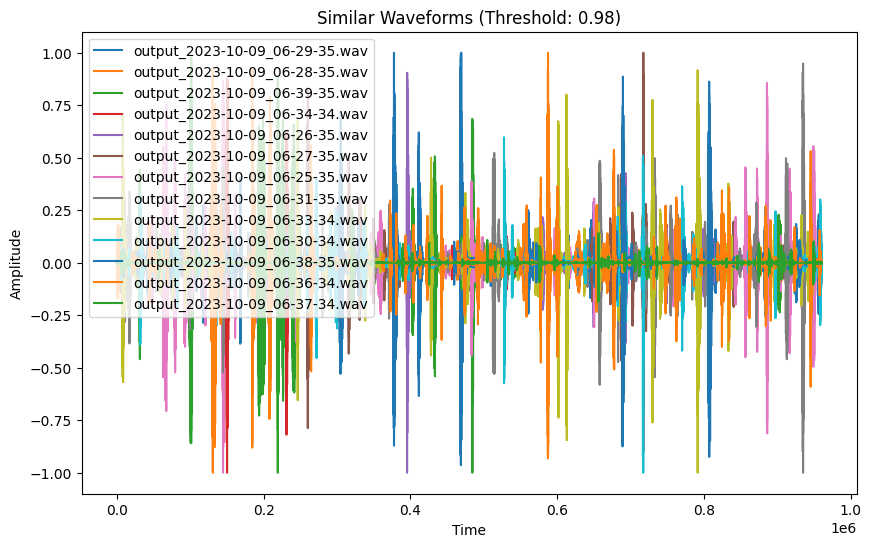

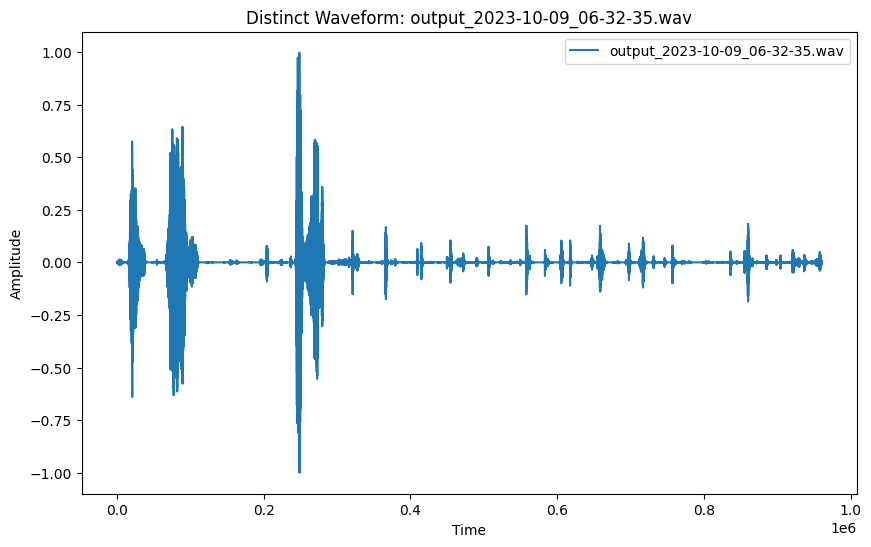

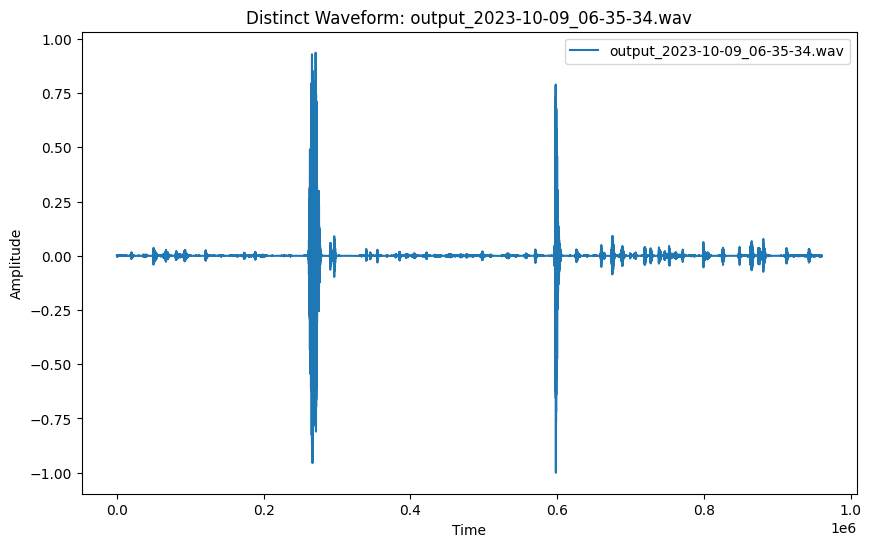

In [31]:
audio_directory = "Audio_Work/birth_inference_minutes_wav/output_2023-10-09_06-33-01"
plot_waveforms_based_on_similarity(audio_directory, similarity_threshold=0.98)

In [45]:
def plot_spectrogram(file_path):
    wav = load_wav_16k_mono(file_path)
    
    # Set the target length for the audio file (e.g., 48000 samples for 3 seconds at 16kHz)
    target_length = 16000

    # Get the actual length of the loaded wav file
    wav_length = tf.shape(wav)[0]

    # Calculate the required padding length (ensure it's not negative)
    padding_length = tf.maximum(target_length - wav_length, 0)

    # Create zero padding tensor
    zero_padding = tf.zeros([padding_length], dtype=tf.float32)

    # Concatenate the audio with zero padding so that all audio files are of the same length
    wav = tf.concat([wav, zero_padding], 0)
    wav = wav[:target_length]

    # Compute the spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)

    # Create the date label
    date_label_match = re.search(r'\d{4}-\d{2}-\d{2}', str(file_path)).group(0)


    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    plt.imshow(tf.math.log(spectrogram + 1e-6).numpy().T, aspect='auto', origin='lower', cmap='inferno')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram for {date_label_match}")
    plt.show()

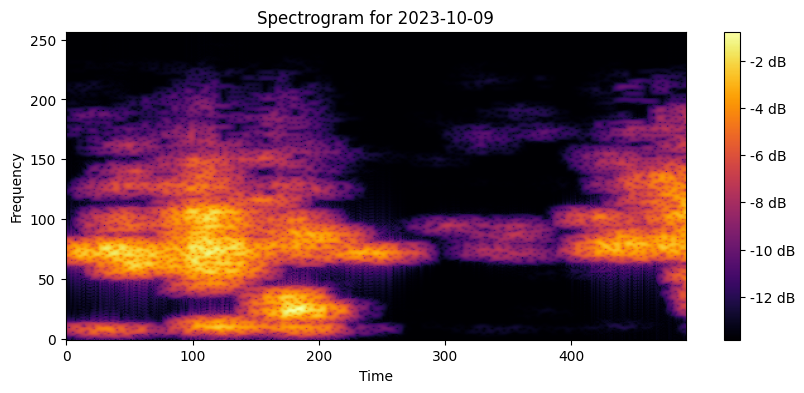

In [46]:
file_path = "Audio_Work/birth_inference_minutes_wav/output_2023-10-09_06-33-01/output_2023-10-09_06-32-35.wav"
plot_spectrogram(file_path)

In [47]:
def plot_spectrogram(file_path, frame_length=320, frame_step=32, use_mel_scale=False):
    wav = load_wav_16k_mono(file_path)
    
    target_length = 16000
    wav_length = tf.shape(wav)[0]
    padding_length = tf.maximum(target_length - wav_length, 0)
    zero_padding = tf.zeros([padding_length], dtype=tf.float32)

    wav = tf.concat([wav, zero_padding], 0)
    wav = wav[:target_length]

    spectrogram = tf.signal.stft(wav, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    if use_mel_scale:
        # Convert to Mel scale
        num_spectrogram_bins = spectrogram.shape[-1]
        lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000.0, 64
        linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
          num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz,
          upper_edge_hertz)
        spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
        spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

        # Create the date label
    date_label_match = re.search(r'\d{4}-\d{2}-\d{2}', str(file_path)).group(0)



    plt.figure(figsize=(10, 4))
    plt.imshow(tf.math.log(spectrogram + 1e-6).numpy().T, aspect='auto', origin='lower', cmap='inferno')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency' if use_mel_scale else 'Frequency')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram for {date_label_match}" if use_mel_scale else "Spectrogram for {date_label_match}")
    plt.show()


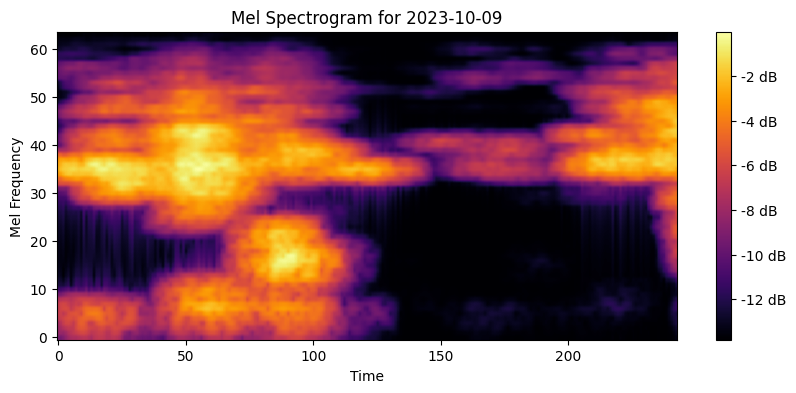

In [48]:
file_path='Audio_Work/birth_inference_minutes_wav/output_2023-10-09_06-33-01/output_2023-10-09_06-32-35.wav'
plot_spectrogram(file_path, frame_length=512, frame_step=64, use_mel_scale=True)